# Setting up DESI KP4 files for use in Barry
This notebook includes code to ingest all the files for DESI Y1 data and mocks, both Abacus and EZmocks, cutsky and cubic, and for multiple tracers and redshift bins. Barry has a strict set of data inputs, and everything gets pickled up into this format. This means the underlying clustering measurements etc., can be in any format.

Barry expects that you will read in/specify and pickle:
* The number of correlated datasets. **We set n_data == 1 below, but this would be 2 if we were providing i.e., NGC+SGC data vectors**
* Pre and post-recon data power spectrum with 5 multipoles (some multipoles can be set to zero if they are not required/measured). **Pre- and Post-recon currently set to None as there is no real data yet**
* N pre and post-recon mock power spectra with 5 multipoles (some can be set to zero if they are not required/measured). **Post-recon currently set to None as there is no post-recon mocks yet**
* Pre and post-recon covariance matrices for the power spectra (some elements/blocks can be set to zero if they are not required/measured) **Post-recon currently set to None as there is no post-recon mocks yet**
* A fiducial cosmology
* A window function convolution matrix (some elements/blocks can be set to the identify matrix if they are not required/measured), corresponding k-binning and integral constraint. Only needed for power spectra
* A compression matrix to convert the 3 even multipoles to 5 even+odd (can be given as a block identity matrix if you are not measuring odd multipoles). Only needed for power spectra.

Correlation functions are similar but a little simpler (only 3 multipoles, and no window function stuff).

The code below reads in all the files for both Abacus and EZmocks for LRGs. Hopefully it can be easily extended to do other tracers and redshift bins. As there is currently no real data, so we just parcel up all the mock measurements and covariance matrices. This is still enough to enable fits to the mock means, and individual realisations.

In [2]:
# Import the necessary packages and set up the fiducial cosmology
import os
import pickle
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from cosmoprimo.fiducial import DESI
from pypower import BaseMatrix, PowerSpectrumSmoothWindow, PowerSpectrumSmoothWindowMatrix, PowerSpectrumOddWideAngleMatrix, setup_logging
from pycorr import TwoPointCorrelationFunction, project_to_multipoles
cosmo = DESI()

In [3]:
# General routines for reading input files, power spectrum, covariance matrix, window function matrix, or odd multipole wideangle matrix

# Correlation function. Juan Mena Fernández style where everything is put into single files per multipole
def getxi(loc, zname):
    sin = pd.read_csv(loc+"/s.txt", comment="#", skiprows=0, delim_whitespace=True, header=None).to_numpy().T[0]
    ximat = [pd.read_csv(loc+f"/Xi_{ell}"+zname+".txt", comment="#", skiprows=0, delim_whitespace=True, header=None).to_numpy().T for ell in [0,2,4]]
    
    res = []
    nmocks = np.shape(ximat[0])[0]
    for i in range(nmocks):
        df = {}
        df["s"] = sin
        for l, ell in enumerate([0, 2, 4]):
            df[f"xi{ell}"] = ximat[l][i]
        res.append(pd.DataFrame(df))
        
    return res

# Correlation function. Christoph Saulder style, where we read in the .npy files and rebin with 4Mpc/h binning
def getxi_cs(loc, zname):
    
    rebinfactor = 4
    
    files = [loc + f for f in os.listdir(loc) if zname in f and ".npy" in f and "poles" not in f]
    files.sort(key=sortfunc)
    
    res = []
    for f in files:
        data = TwoPointCorrelationFunction.load(f)
        data.rebin((rebinfactor, 1))
        df = pd.DataFrame(np.vstack(project_to_multipoles(data)).T, columns=["s", "xi0", "xi2", "xi4"])
        res.append(df)
    return res

# Power Spectrum. Barry needs 5 even+odd multipoles, but the odd ones can be filled with zeros if these haven't been measured, as is done here.
def getpk(loc, zname):
    kin = pd.read_csv(loc+"/k.txt", comment="#", skiprows=0, delim_whitespace=True, header=None).to_numpy().T[0]
    pkmat = [pd.read_csv(loc+f"/Pk_{ell}"+zname+".txt", comment="#", skiprows=0, delim_whitespace=True, header=None).to_numpy().T for ell in [0,2,4]]
    
    res = []
    nmocks = np.shape(pkmat[0])[0]
    for i in range(nmocks):
        df = {}
        df["k"] = kin
        for l, ell in enumerate([0, 2, 4]):
            df[f"pk{ell}"] = pkmat[l][i]
        df["pk1"] = np.zeros(len(df["k"]))
        df["pk3"] = np.zeros(len(df["k"]))
        res.append(pd.DataFrame(df)[["k", "pk0", "pk1", "pk2", "pk3", "pk4"]])
        
    return res

# Window function matrix. The window functions are stored in a dictionary of 'step sizes' i.e., how many bins get stuck together relative to the 
# pk measurements so that we can rebin the P(k) at run time if required. Each step size is a dictionary with:
#    the input and output k binning (w_ks_input, w_ks_output), the window function matrix (w_transform) and integral constraint (w_k0_scale).
# The window function assumes 6 input and 5 output multipoles. For cubic sims, we can set the integral constraint to zero and window matrix to the identity matrix, as is done here.
def getwin_dummy(ks):
    res = {"w_ks_input": ks.copy(), "w_k0_scale": np.zeros(ks.size), "w_transform": np.eye(5 * ks.size, 6 * ks.size), "w_ks_output": ks.copy()}
    return {1: res}  # Step size is one

# The conversion matrix M from Beutler 2019. Used to compute the odd multipole models given the even multipoles. In the absence of wide angle effects, or if we don't care about
# the odd multipoles, we can set this to a block matrix with identity matrices in the appropriate places, as is done here.
def getcomp_dummy(ks):
    matrix = np.zeros((6 * ks.size, 3 * ks.size))
    matrix[: ks.size, : ks.size] = np.diag(np.ones(ks.size))
    matrix[2 * ks.size : 3 * ks.size, ks.size : 2 * ks.size] = np.diag(np.ones(ks.size))
    matrix[4 * ks.size : 5 * ks.size, 2 * ks.size :] = np.diag(np.ones(ks.size))
    return matrix

# Read's in Juan's k-space window multipoles and use the routines in pypower to convert these to window and wideangle matrices
def getwin(ks, winfile):
    
    wa_orders = 1 # wide-angle order
    ellsin = [0, 2, 4] # input (theory) multipoles
    ellsout = [0, 1, 2, 3, 4] # output multipoles
    
    # Check for the presence of window and wide angle matrix files already. If we find both, just load them in
    winmatname = winfile + "_matrix.npy"
    wideanglename = winfile + "_wideangle.npy"
    if os.path.exists(winmatname) and os.path.exists(wideanglename):
    
        wm = BaseMatrix.load(winmatname)
        wam = BaseMatrix.load(wideanglename)
        
    else:

        window = PowerSpectrumSmoothWindow.load(winfile + ".npy")

        sep = np.geomspace(1e-4, 1e4, 1024*16) # configuration space separation for FFTlog
        kin_rebin = 8 # rebin input theory to save memory, and run time when fitting.
        kin_lim = (1e-4, 0.4) # pre-cut input (theory) ks to save some memory
        projsin = ellsin + PowerSpectrumOddWideAngleMatrix.propose_out(ellsin, wa_orders=wa_orders)
        wm = PowerSpectrumSmoothWindowMatrix(ks, projsin=projsin, projsout=ellsout, window=window, sep=sep, kin_rebin=kin_rebin, kin_lim=kin_lim, default_zero=True)
        wam = PowerSpectrumOddWideAngleMatrix(wm.xin[0], projsin=ellsin, projsout=wm.projsin, d=1., wa_orders=wa_orders, los=window.attrs['los_type'])
        
        # Save the matrices
        wm.save(winmatname)
        wam.save(wideanglename)
    
    # The pypower functions store the inner chunks in the order 0, 2, 4, 1, 3, 5, 
    # but Barry expects 0, 1, 2, 3, 4, 5. So let's break the matrices apart and reorder them.
    wm_reshape = np.vsplit(wm.value, 6)
    wm_reshape = np.concatenate([wm_reshape[0],wm_reshape[3],wm_reshape[1],wm_reshape[4],wm_reshape[2],wm_reshape[5]]).T    
    wam_reshape = np.hsplit(wam.value, 6)
    wam_reshape = np.concatenate([wam_reshape[0],wam_reshape[3],wam_reshape[1],wam_reshape[4],wam_reshape[2],wam_reshape[5]], axis=1).T
    
    res = {"w_ks_input": wm.xin[0], "w_k0_scale": np.zeros(ks.size), "w_transform": wm_reshape, "w_ks_output": wm.xout[0]}
    winmat = {1: res}   # Step size is one, but we could modify this to contain other stepsizes too.
    
    return winmat, wam_reshape

# Power spectrum covariance matrix. Needs to have 6 multipoles, but if the some of them haven't been measured, we can set the covariance matrix elements to the identity matrix, as is done here.
def format_pk_cov(nks, covfile):

    cov_input = pd.read_csv(covfile, comment="#", delim_whitespace=True, header=None).to_numpy()
    nin = nks
    cov = np.eye(5 * nks)
    cov[:nks, :nks] = cov_input[:nks, :nks]
    cov[:nks, 2 * nks : 3 * nks] = cov_input[:nks, nin : nin + nks]
    cov[:nks, 4 * nks : 5 * nks] = cov_input[:nks, 2 * nin : 2 * nin + nks]
    cov[2 * nks : 3 * nks, :nks] = cov_input[nin : nin + nks, :nks]
    cov[2 * nks : 3 * nks, 2 * nks : 3 * nks] = cov_input[nin : nin + nks, nin : nin + nks]
    cov[2 * nks : 3 * nks, 4 * nks : 5 * nks] = cov_input[nin : nin + nks, 2 * nin : 2 * nin + nks]
    cov[4 * nks : 5 * nks, :nks] = cov_input[2 * nin : 2 * nin + nks, :nks]
    cov[4 * nks : 5 * nks, 2 * nks : 3 * nks] = cov_input[2 * nin : 2 * nin + nks, nin : nin + nks]
    cov[4 * nks : 5 * nks, 4 * nks : 5 * nks] = cov_input[2 * nin : 2 * nin + nks, 2 * nin : 2 * nin + nks]
    
    # Check the covariance matrix is invertible
    v = np.diag(cov @ np.linalg.inv(cov))
    if not np.all(np.isclose(v, 1)):
        print("ERROR, setting an inappropriate covariance matrix that is almost singular!!!!")
        #print(f"These should all be 1: {v}")
    
    return cov

# Correlation function covariance matrix.
def format_xi_cov(nss, covfile):

    cov_input = pd.read_csv(covfile, comment="#", delim_whitespace=True, header=None).to_numpy()
    nin = nss
    cov = np.zeros((3 * nss, 3 * nss))
    cov[:nss, :nss] = cov_input[:nss, :nss]
    cov[:nss, nss : 2 * nss] = cov_input[:nss, nin : nin + nss]
    cov[:nss, 2 * nss :] = cov_input[:nss, 2 * nin : 2 * nin + nss]
    cov[nss : 2 * nss, :nss] = cov_input[nin : nin + nss, :nss]
    cov[nss : 2 * nss, nss : 2 * nss] = cov_input[nin : nin + nss, nin : nin + nss]
    cov[nss : 2 * nss, 2 * nss :] = cov_input[nin : nin + nss, 2 * nin : 2 * nin + nss]
    cov[2 * nss :, :nss] = cov_input[2 * nin : 2 * nin + nss, :nss]
    cov[2 * nss :, nss : 2 * nss] = cov_input[2 * nin : 2 * nin + nss, nin : nin + nss]
    cov[2 * nss :, 2 * nss :] = cov_input[2 * nin : 2 * nin + nss, 2 * nin : 2 * nin + nss]
    
    # Check the covariance matrix is invertible
    v = np.diag(cov @ np.linalg.inv(cov))
    if not np.all(np.isclose(v, 1)):
        print("ERROR, setting an inappropriate covariance matrix that is almost singular!!!!")
        #print(f"These should all be 1: {v}")

    return cov

# Useful utility function to collate some Pk data
def collect_pk_data(pre_files, post_files, pre_cov_files, post_cov_files, winfile, zeff, zname, name):
    
    pre_res = getpk(pre_file, zname)
    #post_res = getpk(post_files, zname)
    
    ks = pre_res[0]["k"].to_numpy()
    
    pre_cov = format_pk_cov(len(ks), pre_cov_file)
    #post_cov = format_pk_cov(len(ks), post_files + "cov" + zname + ".txt")

    if winfile is not None:
        winmat, wideangle = getwin(ks, winfile)
    else:
        winmat, wideangle = getwin_dummy(ks), getcomp_dummy(ks)
    
    split = {
        "n_data": 1,
        "pre-recon data": None,
        "pre-recon cov": pre_cov,
        "post-recon data": None,
        "post-recon cov": None,
        "pre-recon mocks": [v for v in pre_res],
        "post-recon mocks": None,
        "cosmology": {
            "om": cosmo["Omega_m"],
            "h0": cosmo["h"],
            "z": zeff,
            "ob": cosmo["Omega_b"],
            "ns": cosmo["n_s"],
            "mnu": np.sum(cosmo["m_ncdm"]),
            "reconsmoothscale": 15,
        },
        "name": name,
        "winfit": winmat,
        "winpk": None,  # We can set this to None; Barry will set it to zeroes given the length of the data vector.
        "m_mat": wideangle,
    }
    
    with open(f"../" + name.lower().replace(" ", "_")+".pkl", "wb") as f:
        pickle.dump(split, f)
        
    return split

# Useful utility function to collate some Xi data
def collect_xi_data(pre_files, post_files, pre_cov_file, post_cov_file, zeff, zname, name, dataformat="jmf"):

    pre_res = getxi(pre_files, zname) if dataformat=="jmf" else getxi_cs(pre_files, zname)
    #post_res = getxi(post_files, zname)
    
    ss = pre_res[0]["s"].to_numpy()
    
    pre_cov = format_xi_cov(len(ss), pre_cov_file)
    #post_cov = format_xi_cov(len(ss), post_files + "cov" + zname + ".txt")

    split = {
        "n_data": 1,
        "pre-recon data": None,
        "pre-recon cov": pre_cov,
        "post-recon data": None,
        "post-recon cov": None,
        "pre-recon mocks": [v for v in pre_res],
        "post-recon mocks": None,
        "cosmology": {
            "om": cosmo["Omega_m"],
            "h0": cosmo["h"],
            "z": zeff,
            "ob": cosmo["Omega_b"],
            "ns": cosmo["n_s"],
            "mnu": np.sum(cosmo["m_ncdm"]),
            "reconsmoothscale": 15,
        },
        "name": name,
    }
    
    with open(f"../" + name.lower().replace(" ", "_")+".pkl", "wb") as f:
        pickle.dump(split, f)
        
    return split

# Plot the power spectra, for sanity checking
def plot_pk(split):
    
    color = ["r", "b", "g"]
    ks = split["pre-recon mocks"][0]["k"]
    nmocks = len(split["pre-recon mocks"])
    label = [r"$P_{0}(k)$", r"$P_{2}(k)$", r"$P_{4}(k)$"]
    for m, pk in enumerate(["pk0", "pk2", "pk4"]):
        yerr = ks * np.sqrt(np.diag(split["pre-recon cov"]))[2 * m * len(ks) : (2 * m + 1) * len(ks)]
        plt.errorbar(
            ks,
            ks * np.mean([split["pre-recon mocks"][i][pk] for i in range(nmocks)], axis=0),
            yerr=yerr,
            marker="o",
            ls="None",
            c=color[m],
            label=label[m],
        )
        for i in range(nmocks):
            plt.errorbar(ks, ks * split["pre-recon mocks"][i][pk], marker="None", ls="-", c='k', alpha=1.0 / nmocks**(3.0/4.0))
    plt.xlabel(r"$k$")
    plt.ylabel(r"$k\,P(k)$")
    plt.title(split["name"])
    plt.legend()
    plt.show()
    
# Plot the power spectra, for sanity checking
def plot_xi(split):
    
    color = ["r", "b", "g"]
    ss = split["pre-recon mocks"][0]["s"]
    nmocks = len(split["pre-recon mocks"])
    label = [r"$\xi_{0}(k)$", r"$\xi_{2}(k)$", r"$\xi_{4}(k)$"]
    for m, xi in enumerate(["xi0", "xi2", "xi4"]):
        yerr = ss ** 2 * np.sqrt(np.diag(split["pre-recon cov"]))[m * len(ss) : (m + 1) * len(ss)]
        plt.errorbar(
            ss,
            ss ** 2 * np.mean([split["pre-recon mocks"][i][xi] for i in range(nmocks)], axis=0),
            yerr=yerr,
            marker="o",
            ls="None",
            c=color[m],
            label=label[m],
        )
        for i in range(nmocks):
            plt.errorbar(ss, ss ** 2 * split["pre-recon mocks"][i][xi], marker="None", ls="-", c='k', alpha=1.0 / nmocks**(3.0/4.0))
    plt.xlabel(r"$s$")
    plt.ylabel(r"$s^{2}\,\xi(s)$")
    plt.title(split["name"])
    plt.legend()
    plt.show()
    
# A useful sort function
def sortfunc(item):
    if "EZmock" in item:
        return int(item.split("_")[3][:-4])
    else:
        return int(item.split("_")[7][2:])

# Abacus Cubic Mocks

ERROR, setting an inappropriate covariance matrix that is almost singular!!!!


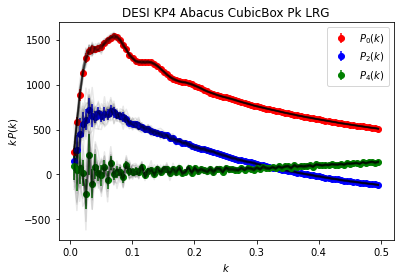

ERROR, setting an inappropriate covariance matrix that is almost singular!!!!


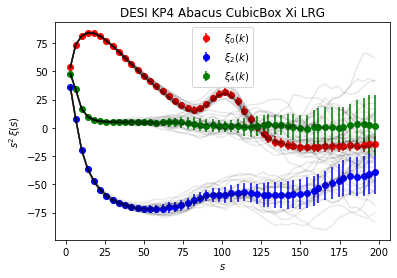

In [4]:
# Loop over tracers
path = "/global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CubicBox/"
for tracer in ["LRG"]:
    
    # Power Spectrum
    pre_file = path + "Pk/jmena/nmesh_512/dk0.005/"
    pre_cov_file = path + "Pk/jmena/nmesh_512/dk0.005/cov.txt"
    name = f"DESI KP4 Abacus CubicBox Pk " + tracer
    data = collect_pk_data(pre_file, None, pre_cov_file, None, None, 0.8, "", name)
    plot_pk(data) # Plot the data to check things
   
    # Correlation Function
    pre_file = path + "Xi/jmena/"
    pre_cov_file = path + "Xi/jmena/cov.txt"
    name = f"DESI KP4 Abacus CubicBox Xi " + tracer
    data = collect_xi_data(pre_file, None, pre_cov_file, None, 0.8, "", name)
    plot_xi(data) # Plot the data to check things

# Abacus CutSky Mocks

[003454.01]  04-20 22:20  BaseMatrix                   INFO     Loading /global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CutSky/LRG/Pk/jmena/nmesh_1024/window_combined_zmin0.4_zmax0.6_matrix.npy.
[003454.30]  04-20 22:20  BaseMatrix                   INFO     Loading /global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CutSky/LRG/Pk/jmena/nmesh_1024/window_combined_zmin0.4_zmax0.6_wideangle.npy.


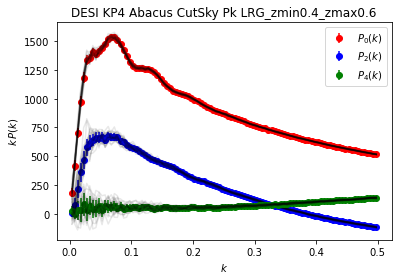

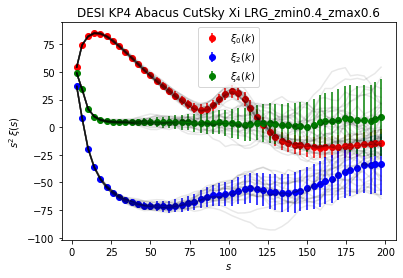

[003456.24]  04-20 22:20  BaseMatrix                   INFO     Loading /global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CutSky/LRG/Pk/jmena/nmesh_1024/window_combined_zmin0.6_zmax0.8_matrix.npy.
[003456.37]  04-20 22:20  BaseMatrix                   INFO     Loading /global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CutSky/LRG/Pk/jmena/nmesh_1024/window_combined_zmin0.6_zmax0.8_wideangle.npy.


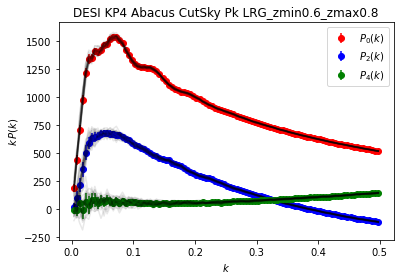

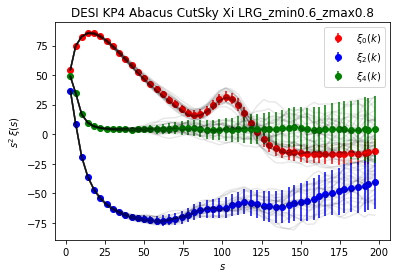

[003457.93]  04-20 22:20  BaseMatrix                   INFO     Loading /global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CutSky/LRG/Pk/jmena/nmesh_1024/window_combined_zmin0.8_zmax1.1_matrix.npy.
[003458.05]  04-20 22:20  BaseMatrix                   INFO     Loading /global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CutSky/LRG/Pk/jmena/nmesh_1024/window_combined_zmin0.8_zmax1.1_wideangle.npy.


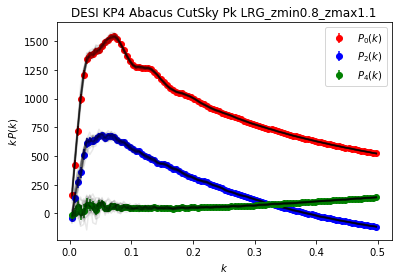

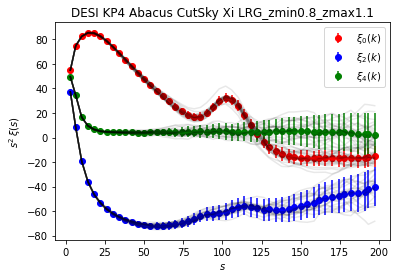

In [44]:
# Loop over tracers and redshift bins
path_abacus = "/global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CutSky/"
path_ezmock = "/global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/EZmock/CutSky/"

# Dictionary containing zmin, zmax and zeff for the tracers
reds = {"LRG": [["0.4", "0.6", 0.5], ["0.6", "0.8", 0.7], ["0.8", "1.1", 0.95]]}

for tracer in ["LRG"]:
    for i, (zmin, zmax, zeff) in enumerate(reds[tracer]):
        
        # Power Spectrum
        zname = "_zmin" + zmin + "_zmax" + zmax
        pre_file = path_abacus + tracer + "/Pk/jmena/nmesh_1024/dk0.005/"
        # Use the EZmock covariance rather than Abacus.
        #pre_cov_file = path_abacus + tracer + f"/Pk/jmena/nmesh_1024/dk0.005/cov" + zname + ".txt"
        pre_cov_file = path_ezmock + tracer + f"/Pk/jmena/nmesh_1024/dk0.005/cov" + zname + ".txt"
        winfile = path_abacus + tracer + f"/Pk/jmena/nmesh_1024/window_combined" + zname
        name = f"DESI KP4 Abacus CutSky Pk " + tracer + zname
        data = collect_pk_data(pre_file, None, pre_cov_file, None, winfile, zeff, zname, name)
        plot_pk(data) # Plot the data to check things

        # Correlation Function
        pre_file = path_abacus + tracer + "/Xi/jmena/"
        # Use the EZmock covariance rather than Abacus.
        #pre_cov_file = path_abacus + tracer + f"/Xi/jmena/cov" + zname + ".txt"
        pre_cov_file = path_abacus + tracer + f"/Xi/csaulder/cov/{zmin[2]}{zmax[2]}_cov.dat"
        name = f"DESI KP4 Abacus CutSky Xi " + tracer + zname
        data = collect_xi_data(pre_file, None, pre_cov_file, None, zeff, zname, name)
        plot_xi(data) # Plot the data to check things

# EZmocks CutSky

[003463.07]  04-20 22:20  BaseMatrix                   INFO     Loading /global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CutSky/LRG/Pk/jmena/nmesh_1024/window_combined_zmin0.4_zmax0.6_matrix.npy.
[003463.12]  04-20 22:20  BaseMatrix                   INFO     Loading /global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CutSky/LRG/Pk/jmena/nmesh_1024/window_combined_zmin0.4_zmax0.6_wideangle.npy.


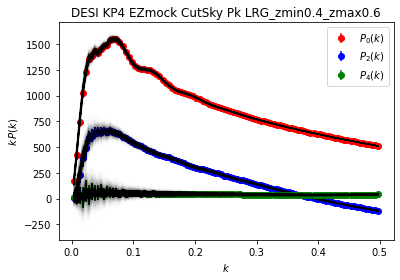

[003470.77]  04-20 22:20  TwoPointEstimator            INFO     Loading /global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CutSky/LRG/Xi/csaulder/EZmocks/EZmock_results_46_1.npy.
[003470.88]  04-20 22:20  TwoPointEstimator            INFO     Loading /global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CutSky/LRG/Xi/csaulder/EZmocks/EZmock_results_46_2.npy.
[003470.97]  04-20 22:20  TwoPointEstimator            INFO     Loading /global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CutSky/LRG/Xi/csaulder/EZmocks/EZmock_results_46_3.npy.
[003471.03]  04-20 22:20  TwoPointEstimator            INFO     Loading /global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CutSky/LRG/Xi/csaulder/EZmocks/EZmock_results_46_4.npy.
[003471.14]  04-20 22:20  TwoPointEstimator            INFO     Loading /global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CutSky/LRG/Xi/csaulder/EZmocks/EZmock_results_46_5.npy.
[003471.20]  04-20 22:20  TwoPointEstima

/global/common/software/desi/users/adematti/cori/cosmodesiconda/20220420-1.0.0/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


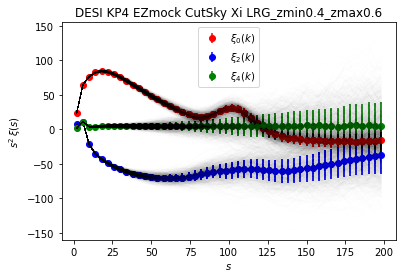

[003529.34]  04-20 22:21  BaseMatrix                   INFO     Loading /global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CutSky/LRG/Pk/jmena/nmesh_1024/window_combined_zmin0.6_zmax0.8_matrix.npy.
[003529.39]  04-20 22:21  BaseMatrix                   INFO     Loading /global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CutSky/LRG/Pk/jmena/nmesh_1024/window_combined_zmin0.6_zmax0.8_wideangle.npy.


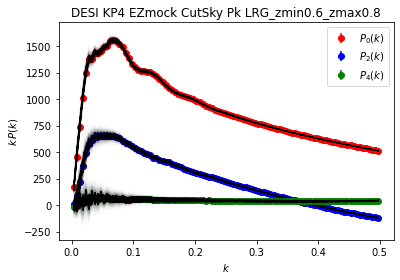

[003536.38]  04-20 22:21  TwoPointEstimator            INFO     Loading /global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CutSky/LRG/Xi/csaulder/EZmocks/EZmock_results_68_1.npy.
[003536.42]  04-20 22:21  TwoPointEstimator            INFO     Loading /global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CutSky/LRG/Xi/csaulder/EZmocks/EZmock_results_68_2.npy.
[003536.46]  04-20 22:21  TwoPointEstimator            INFO     Loading /global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CutSky/LRG/Xi/csaulder/EZmocks/EZmock_results_68_3.npy.
[003536.51]  04-20 22:21  TwoPointEstimator            INFO     Loading /global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CutSky/LRG/Xi/csaulder/EZmocks/EZmock_results_68_4.npy.
[003536.54]  04-20 22:21  TwoPointEstimator            INFO     Loading /global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CutSky/LRG/Xi/csaulder/EZmocks/EZmock_results_68_5.npy.
[003536.58]  04-20 22:21  TwoPointEstima

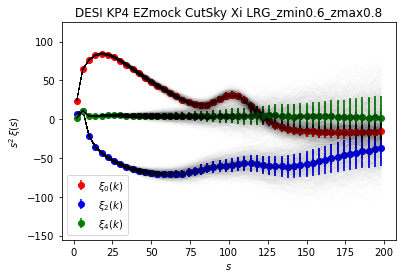

[003585.93]  04-20 22:22  BaseMatrix                   INFO     Loading /global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CutSky/LRG/Pk/jmena/nmesh_1024/window_combined_zmin0.8_zmax1.1_matrix.npy.
[003585.97]  04-20 22:22  BaseMatrix                   INFO     Loading /global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CutSky/LRG/Pk/jmena/nmesh_1024/window_combined_zmin0.8_zmax1.1_wideangle.npy.


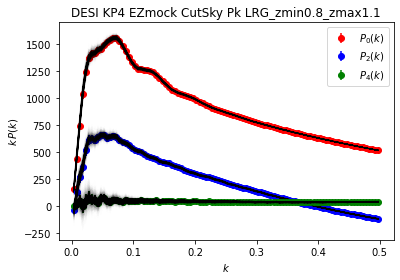

[003593.21]  04-20 22:22  TwoPointEstimator            INFO     Loading /global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CutSky/LRG/Xi/csaulder/EZmocks/EZmock_results_81_1.npy.
[003593.25]  04-20 22:22  TwoPointEstimator            INFO     Loading /global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CutSky/LRG/Xi/csaulder/EZmocks/EZmock_results_81_2.npy.
[003593.28]  04-20 22:22  TwoPointEstimator            INFO     Loading /global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CutSky/LRG/Xi/csaulder/EZmocks/EZmock_results_81_3.npy.
[003593.33]  04-20 22:22  TwoPointEstimator            INFO     Loading /global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CutSky/LRG/Xi/csaulder/EZmocks/EZmock_results_81_4.npy.
[003593.37]  04-20 22:22  TwoPointEstimator            INFO     Loading /global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CutSky/LRG/Xi/csaulder/EZmocks/EZmock_results_81_5.npy.
[003593.40]  04-20 22:22  TwoPointEstima

/global/common/software/desi/users/adematti/cori/cosmodesiconda/20220420-1.0.0/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


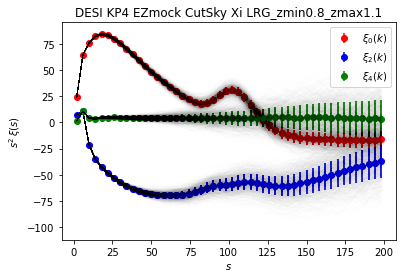

In [45]:
# Loop over tracers and redshift bins
path_abacus = "/global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CutSky/"
path_ezmock = "/global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/EZmock/CutSky/"

# Dictionary containing zmin, zmax and zeff for the tracers
reds = {"LRG": [["0.4", "0.6", 0.5], ["0.6", "0.8", 0.7], ["0.8", "1.1", 0.95]]}

for tracer in ["LRG"]:
    for i, (zmin, zmax, zeff) in enumerate(reds[tracer]):
                
        # Power Spectrum
        zname = "_zmin" + zmin + "_zmax" + zmax
        pre_file = path_ezmock + tracer + "/Pk/jmena/nmesh_1024/dk0.005/"
        pre_cov_file = path_ezmock + tracer + f"/Pk/jmena/nmesh_1024/dk0.005/cov" + zname + ".txt"
        winfile = path_abacus + tracer + f"/Pk/jmena/nmesh_1024/window_combined" + zname
        name = f"DESI KP4 EZmock CutSky Pk " + tracer + zname
        data = collect_pk_data(pre_file, None, pre_cov_file, None, winfile, zeff, zname, name)
        plot_pk(data) # Plot the data to check things

        # Correlation Function
        zname_cs = f"_{zmin[2]}{zmax[2]}_"
        pre_file = path_abacus + tracer + "/Xi/csaulder/EZmocks/"
        pre_cov_file = path_abacus + tracer + f"/Xi/csaulder/cov/{zmin[2]}{zmax[2]}_cov.dat"
        name = f"DESI KP4 EZmock CutSky Xi " + tracer + zname
        data = collect_xi_data(pre_file, None, pre_cov_file, None, zeff, zname_cs, name, dataformat="cs")
        plot_xi(data) # Plot the data to check things